In [127]:
#Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path 
from scipy.stats import entropy

In [5]:
#Import Cleaned Data
data = pd.read_csv("./../data/clean_data.csv", index_col="Video_Number")
data.head()

,Date_Recorded,Hours_CI_Students,Hours_Reading,Hours_Talking,Hours_Native_Media,Time_Recorded,Length_Minutes,Total_Words,Filler_Words,Unique_Words,Avg_Word_Freq,Med_Word_Freq,Entropy,TTR
Video_Number,,,,,,,,,,,,,,
1,2024-10-28,2.5,0.50,0.5,2.0,11:33,13.25,1077,118,296,3.638514,1.0,7.017286,0.274838
2,2024-10-29,1.5,0.00,1.0,3.5,10:54,9.18,790,76,273,2.893773,1.0,6.966307,0.345570
3,2024-10-30,3.0,1.00,1.0,2.0,21:50,7.03,527,48,209,2.521531,1.0,6.710372,0.396584
4,2024-10-31,2.5,1.25,0.0,2.5,23:36,11.92,933,111,306,3.049020,1.0,6.954690,0.327974
5,2024-11-01,1.5,1.00,0.0,1.5,23:27,8.27,615,56,214,2.873832,1.0,6.628696,0.347967


In [7]:
#Let's look at the description of each variable and see if anything stands out

data.describe()

,Hours_CI_Students,Hours_Reading,Hours_Talking,Hours_Native_Media,Length_Minutes,Total_Words,Filler_Words,Unique_Words,Avg_Word_Freq,Med_Word_Freq,Entropy,TTR
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.0,112.000000,112.000000
mean,0.832589,0.511161,0.388393,3.064732,9.589107,910.732143,71.383929,276.723214,3.210958,1.0,6.891041,0.317795
std,1.092763,0.709800,0.604822,1.463807,2.777628,326.888442,24.384032,63.047131,0.467117,0.0,0.168120,0.044874
min,0.000000,0.000000,0.000000,0.000000,5.120000,459.000000,23.000000,171.000000,2.390625,1.0,6.346722,0.227094
25%,0.000000,0.000000,0.000000,2.000000,7.420000,664.250000,55.750000,230.750000,2.932008,1.0,6.778526,0.290957
50%,0.000000,0.250000,0.125000,3.000000,8.835000,839.500000,67.500000,266.500000,3.143714,1.0,6.880027,0.318095
75%,2.000000,0.750000,0.500000,4.000000,11.397500,1047.000000,85.250000,310.500000,3.437182,1.0,7.006264,0.341074
max,3.750000,3.250000,3.000000,10.250000,16.050000,2037.000000,140.000000,470.000000,4.403465,1.0,7.389269,0.418301


In [9]:
#The only variable that stands out to me as useless is Med_Word_Freq. Every value is 1, it is useless for showing patterns
#But, it does show that in most videos more than half of the unique words said are only said once.

#Dropping Med_Word_Freq
data.drop(columns=["Med_Word_Freq"], inplace=True)

In [75]:
#Now for some Feature Engineering
#One large problem looming over us is that all of the videos are of different lengths, and so things like word counts, uniqueness, and other measures
#    can be greatly influenced by video length instead of speaking ability.
#For this reason, it is very important that we normalize or scale the data. Here, we will normalize by dividing time dependent variables by time,
#    to get measurements like Words_Per_Minute in stead of Total_Words (because the time needed to say those words is really relevant to ability)

#Note: Words_Per_Minute = WPM

#Basic PM measures
data["WPM"] = data["Total_Words"] / data["Length_Minutes"]
data["Filler_WPM"] = data["Filler_Words"] / data["Length_Minutes"]
data["Unique_WPM"] = data["Unique_Words"] / data["Length_Minutes"]


#I'm also interested in looking at filler words / total_words as a % rate over time (to normalize that as well with spoken words instead of time passed)
data["Filler_Perc"] = data["Filler_Words"] / data["Total_Words"]

#Total hours is a good measure to have as well for the future
data["Total_Hours"] = data["Hours_CI_Students"] + data["Hours_Reading"] + data["Hours_Talking"] + data["Hours_Native_Media"]

#These are all I have in mind right now. There are some relationships I'd like to explore, like how Length_Minutes and Entropy / TRR are related

#One more thought of later, the video number, right now it is the index. I want to use it for plotting (since the dates are not necessarily important
data["Vid_Num"] = list(range(1,113))

In [13]:
#Verify the new measures make sense
data.describe()

,Hours_CI_Students,Hours_Reading,Hours_Talking,Hours_Native_Media,Length_Minutes,Total_Words,Filler_Words,Unique_Words,Avg_Word_Freq,Entropy,TTR,WPM,Filler_WPM,Unique_WPM,Filler_Perc,Total_Hours
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,0.832589,0.511161,0.388393,3.064732,9.589107,910.732143,71.383929,276.723214,3.210958,6.891041,0.317795,94.171899,7.480519,29.518787,0.080713,4.796875
std,1.092763,0.709800,0.604822,1.463807,2.777628,326.888442,24.384032,63.047131,0.467117,0.168120,0.044874,14.001202,1.572417,3.536055,0.018746,1.730597
min,0.000000,0.000000,0.000000,0.000000,5.120000,459.000000,23.000000,171.000000,2.390625,6.346722,0.227094,66.803279,3.192338,21.867518,0.029304,0.500000
25%,0.000000,0.000000,0.000000,2.000000,7.420000,664.250000,55.750000,230.750000,2.932008,6.778526,0.290957,82.601915,6.566721,26.981774,0.068114,4.000000
50%,0.000000,0.250000,0.125000,3.000000,8.835000,839.500000,67.500000,266.500000,3.143714,6.880027,0.318095,94.277434,7.438248,29.759149,0.080824,4.875000
75%,2.000000,0.750000,0.500000,4.000000,11.397500,1047.000000,85.250000,310.500000,3.437182,7.006264,0.341074,103.963492,8.570646,32.197608,0.093267,6.000000
max,3.750000,3.250000,3.000000,10.250000,16.050000,2037.000000,140.000000,470.000000,4.403465,7.389269,0.418301,137.635135,11.454754,38.671875,0.122671,11.000000


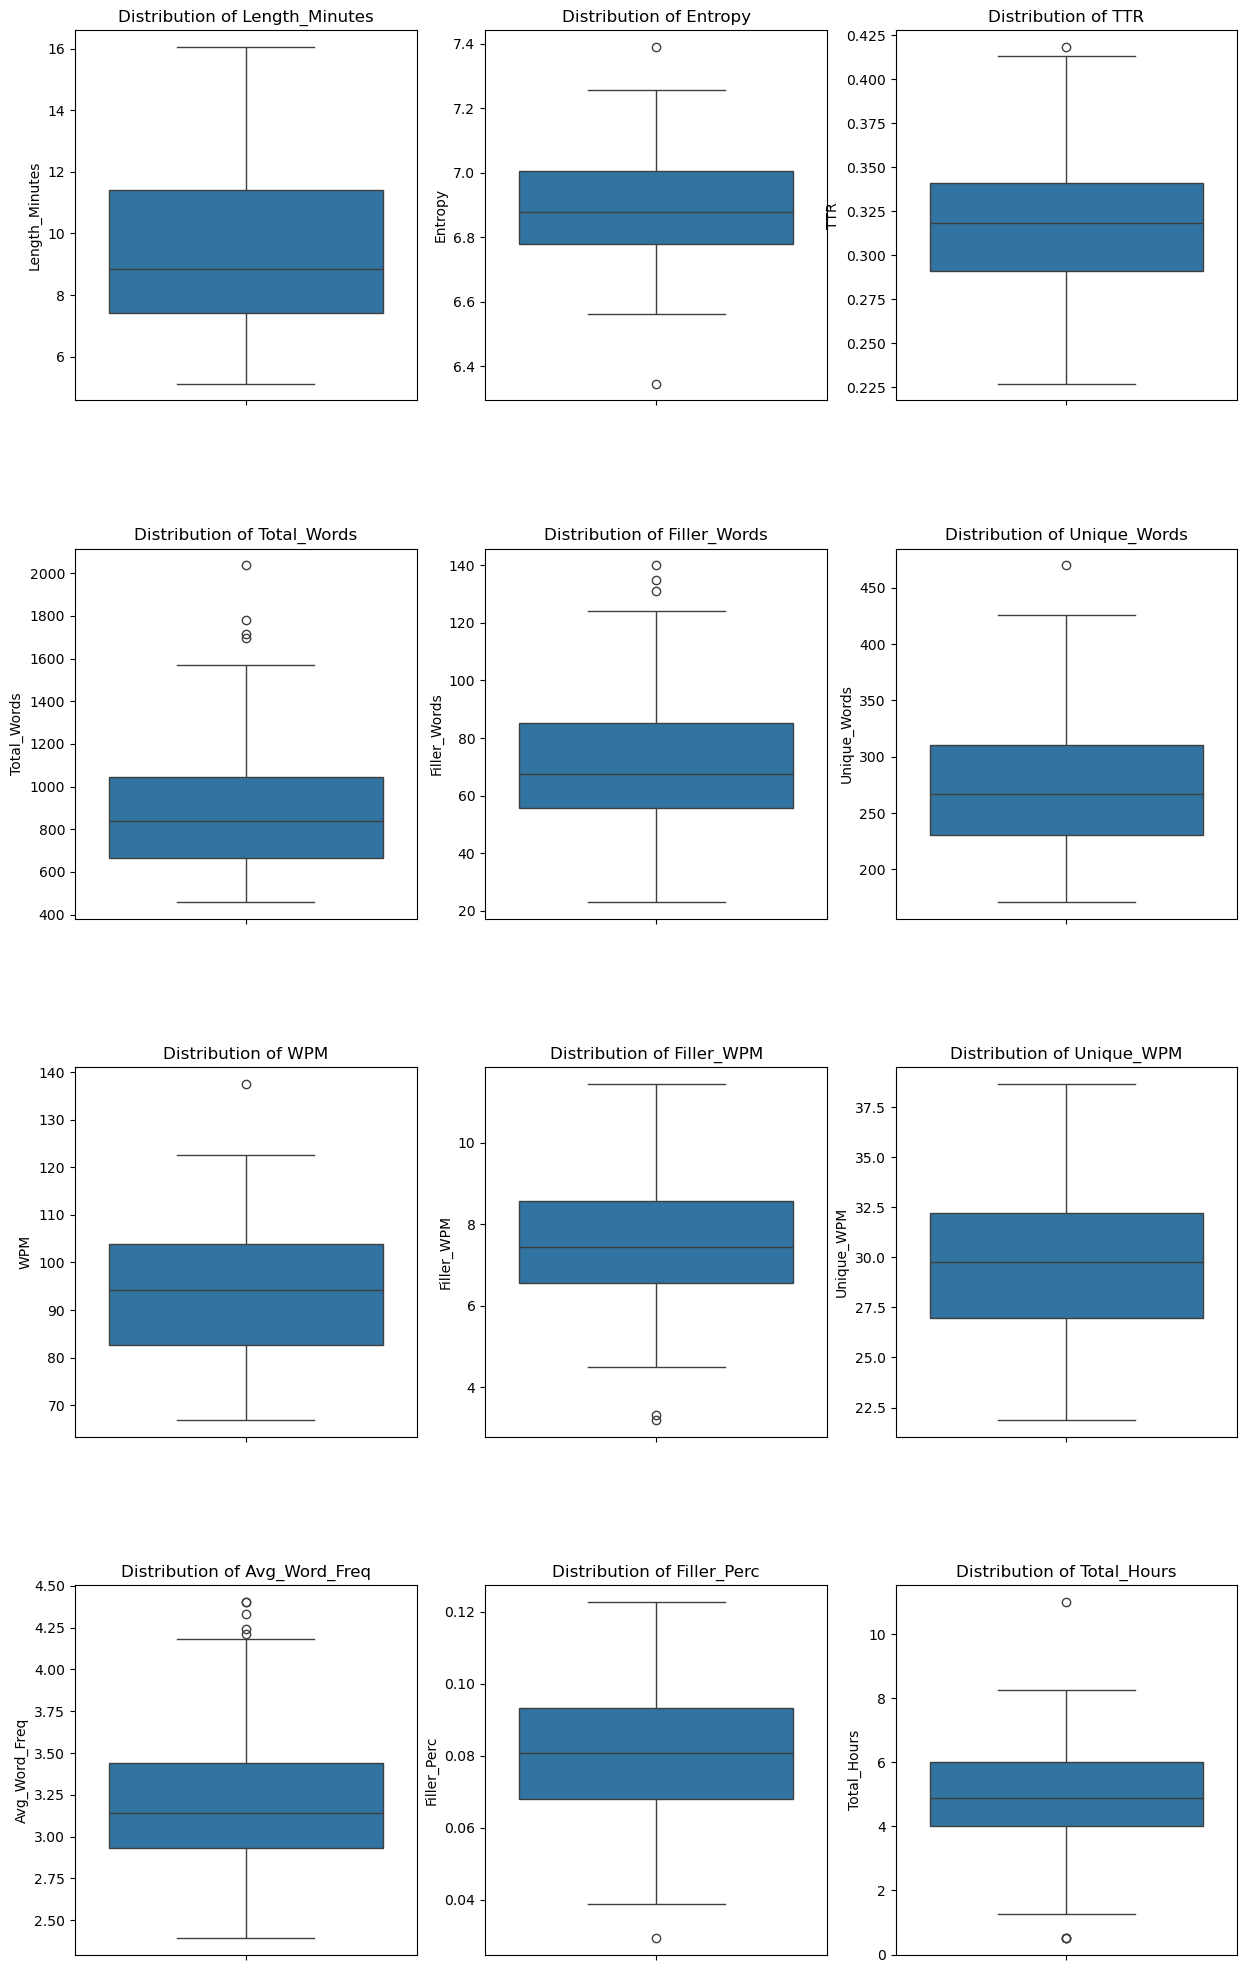

In [25]:
#Now let's look at the distribution of different variables

#Creating a 4 row, 3 col grid of boxplots to show the distributions all next to eachother (and shorten workbook size)
fig, axes = plt.subplots(4, 3, figsize=(15, 25))  # 4 rows, 3 columns
fig.subplots_adjust(hspace=0.4)

#List of variables we want to look at
categories = ["Length_Minutes", "Entropy", "TTR", "Total_Words", "Filler_Words", "Unique_Words", 
              "WPM", "Filler_WPM", "Unique_WPM", "Avg_Word_Freq", "Filler_Perc", "Total_Hours"]

for i in range(12):
    row, col = divmod(i, 3)  # Get grid position
    sns.boxplot(y=data[categories[i]], ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {categories[i]}')  # Set title for each boxplot according to variable name

In [33]:
#Now I'm going to look into the outlier observations to see if there are any observations that have two variables which are outliers above.

print(data.nlargest(5, "Entropy"))

#Here we see that the last video was an outlier in many regards. It had the most words, the highest entropy, the lowest TTR, and highest WPM
#This can probably be explained by general excitement and nervousness since I knew that video would be shared as part of the project (2-111 are private)

             Date_Recorded  Hours_CI_Students  Hours_Reading  Hours_Talking  \
Video_Number                                                                  
112             2025-02-19               0.00           0.00           1.25   
40              2024-12-06               2.50           0.25           1.50   
108             2025-02-15               0.00           0.00           0.50   
36              2024-12-02               2.25           0.25           0.00   
78              2025-01-16               0.00           1.00           0.00   

              Hours_Native_Media Time_Recorded  Length_Minutes  Total_Words  \
Video_Number                                                                  
112                         2.00         15:33           14.80         2037   
40                          1.25         13:16           14.75         1568   
108                         3.75         23:48           14.80         1523   
36                          2.50         20:44     

In [37]:
print(data.nlargest(5, "Total_Words"))

#So the 4 outliers are all from very recent videos which were long in length. Also with good Entropy and TTR scores
#One thing to note is that the 5th highest (non outlier) is from Day 40, and you can see improvement in the normalized metrics! 
#Basically, these are outliers in the sense that they were longer than many videos and the skill level was higher, so of course there are more words

             Date_Recorded  Hours_CI_Students  Hours_Reading  Hours_Talking  \
Video_Number                                                                  
112             2025-02-19                0.0           0.00           1.25   
101             2025-02-08                0.0           0.00           0.75   
104             2025-02-11                0.0           0.00           0.00   
103             2025-02-10                0.0           0.00           0.00   
40              2024-12-06                2.5           0.25           1.50   

              Hours_Native_Media Time_Recorded  Length_Minutes  Total_Words  \
Video_Number                                                                  
112                         2.00         15:33           14.80         2037   
101                         4.75         23:53           14.97         1779   
104                         4.00         23:47           16.05         1715   
103                         3.00         21:16     

In [43]:
print(data.nlargest(6, "Filler_Words"))

#These are all longer videos from towards the beginning of the project (the first 3)
#When looking at the next I noticed video #1 is 6th place! 
#One thing to note is that the Filler_Perc is much lower for Video 92 and 71 than the other 4. Meaning frequency based normalization helped us again!

             Date_Recorded  Hours_CI_Students  Hours_Reading  Hours_Talking  \
Video_Number                                                                  
28              2024-11-24               2.00           1.75           0.25   
32              2024-11-28               2.00           0.00           0.25   
27              2024-11-23               2.25           1.75           1.25   
92              2025-01-30               0.00           0.00           1.50   
71              2025-01-09               0.75           1.00           0.25   
1               2024-10-28               2.50           0.50           0.50   

              Hours_Native_Media Time_Recorded  Length_Minutes  Total_Words  \
Video_Number                                                                  
28                          2.50         20:17           14.63         1208   
32                          2.25         22:43           14.57         1401   
27                          3.00         22:08     

In [45]:
print(data.nsmallest(5, "Filler_WPM"))

#Now this is interesting. Video 111 had the lowest, and the next was Video 10. However, Video 111 is almost double the length
#Many of these videos tend to be below average length. I wander if mumbling might attribute to lower WPM

             Date_Recorded  Hours_CI_Students  Hours_Reading  Hours_Talking  \
Video_Number                                                                  
111             2025-02-18               0.00            0.0           1.00   
10              2024-11-06               3.25            0.0           0.50   
7               2024-11-03               3.00            2.0           0.00   
8               2024-11-04               3.75            1.0           0.25   
20              2024-11-16               1.50            0.0           1.00   

              Hours_Native_Media Time_Recorded  Length_Minutes  Total_Words  \
Video_Number                                                                  
111                         4.50         22:36           12.53         1365   
10                          3.25         21:20            6.93          593   
7                           2.00         00:20            6.23          485   
8                           1.00         23:00     

In [49]:
#Just to finish off the set of three measures related to filler words. I'm interested in seeing how the low outliers relate

print(data.nsmallest(5, "Filler_Perc"))

#Video 111 is also the lowest here, makes sense since it was also long. Video 10 is still here, but after that the videos are more recent
#I wonder if this metric will show a stronger decrease than Filler_WPM over time

             Date_Recorded  Hours_CI_Students  Hours_Reading  Hours_Talking  \
Video_Number                                                                  
111             2025-02-18               0.00            0.0            1.0   
10              2024-11-06               3.25            0.0            0.5   
105             2025-02-12               0.00            0.0            0.0   
108             2025-02-15               0.00            0.0            0.5   
106             2025-02-13               0.00            0.0            1.0   

              Hours_Native_Media Time_Recorded  Length_Minutes  Total_Words  \
Video_Number                                                                  
111                         4.50         22:36           12.53         1365   
10                          3.25         21:20            6.93          593   
105                         5.25         00:01           11.62         1379   
108                         3.75         23:48     

In [47]:
print(data.nlargest(5, "Avg_Word_Freq"))

#One thing that is interesting here is that all of these are newer videos with longer length.
#This variable doesn't have a normalization respective to time passed, but I suspect that with more time in a video, this increases
#Maybe this variable needs some rethinking if we want to use it to support important outcomes later in the analysis

             Date_Recorded  Hours_CI_Students  Hours_Reading  Hours_Talking  \
Video_Number                                                                  
101             2025-02-08                0.0            0.0           0.75   
87              2025-01-25                0.0            0.0           1.00   
112             2025-02-19                0.0            0.0           1.25   
111             2025-02-18                0.0            0.0           1.00   
102             2025-02-09                0.0            0.0           0.00   

              Hours_Native_Media Time_Recorded  Length_Minutes  Total_Words  \
Video_Number                                                                  
101                         4.75         23:53           14.97         1779   
87                          2.00         23:34           13.83         1426   
112                         2.00         15:33           14.80         2037   
111                         4.50         22:36     

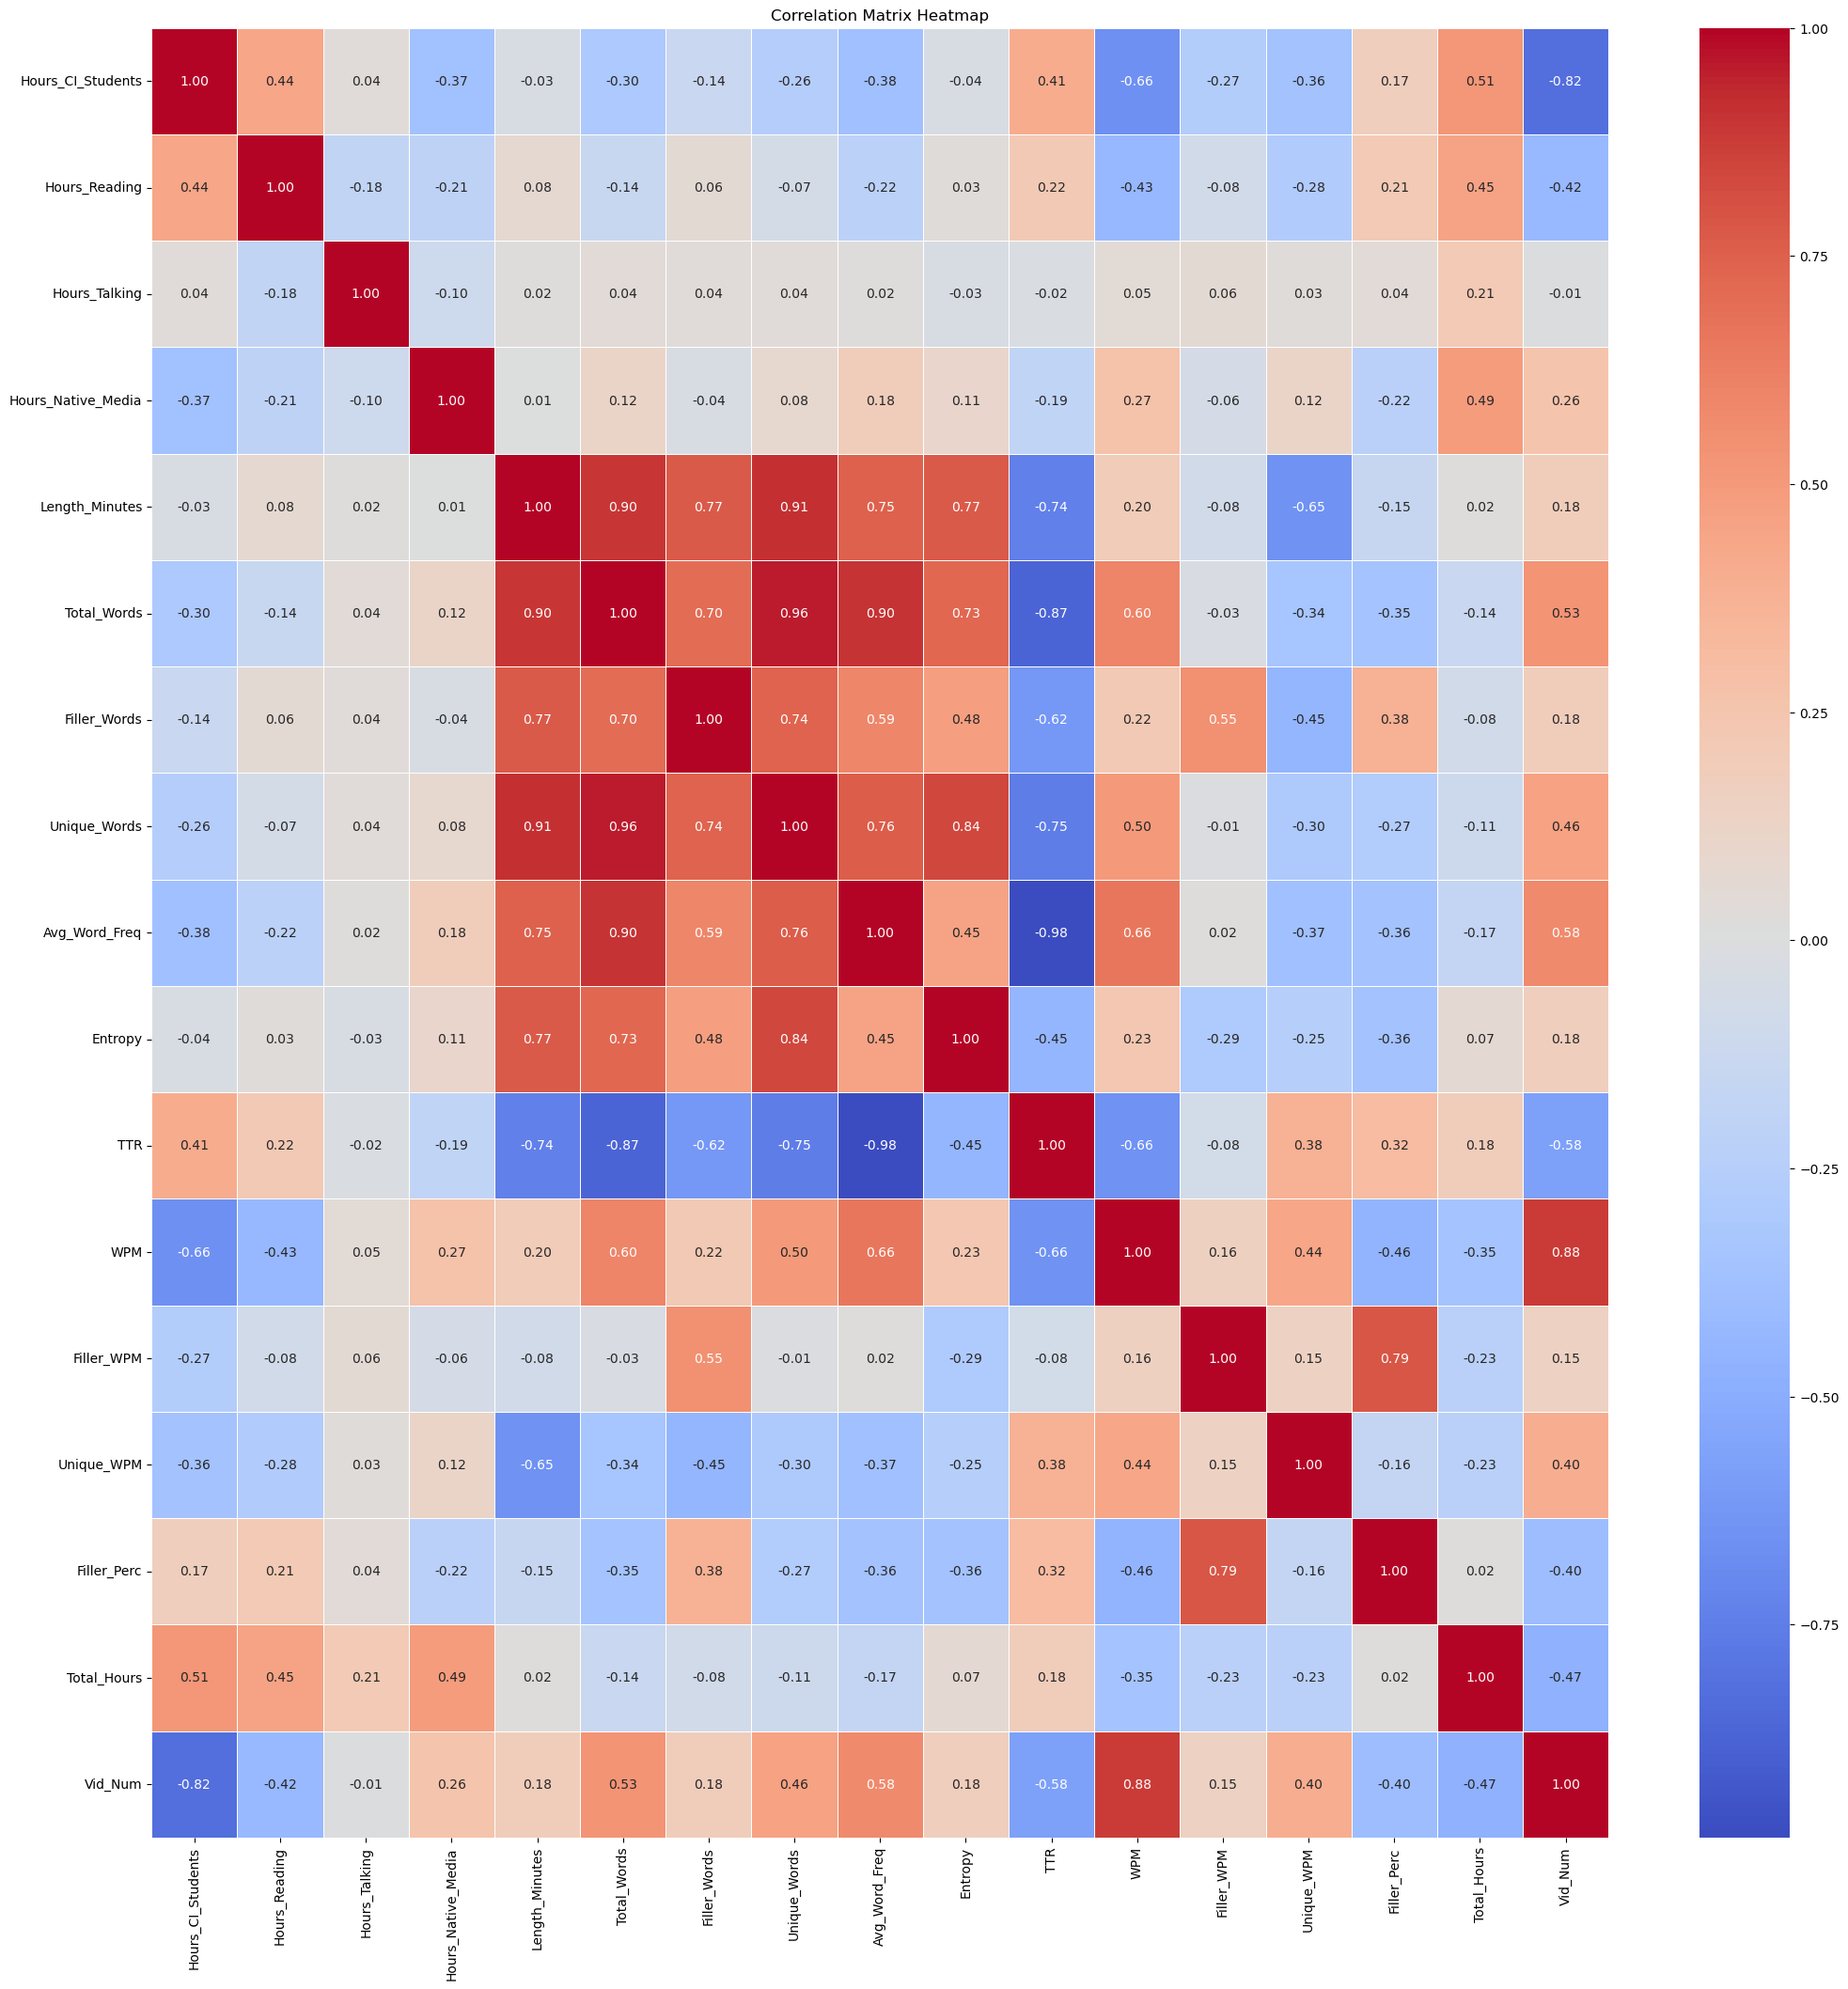

In [63]:
#Now I want to look at correlations and relationships within the data to see if anything stands out

#Filter for only numerical data. Also, I want to include Video_Number as a way to show correlation with time passing
data_num = data.drop(columns=["Date_Recorded", "Time_Recorded"])
data_num["Vid_Num"] = list(range(1,113))

#Generate and plot heatmap
corr_matrix = data_num.corr()
plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

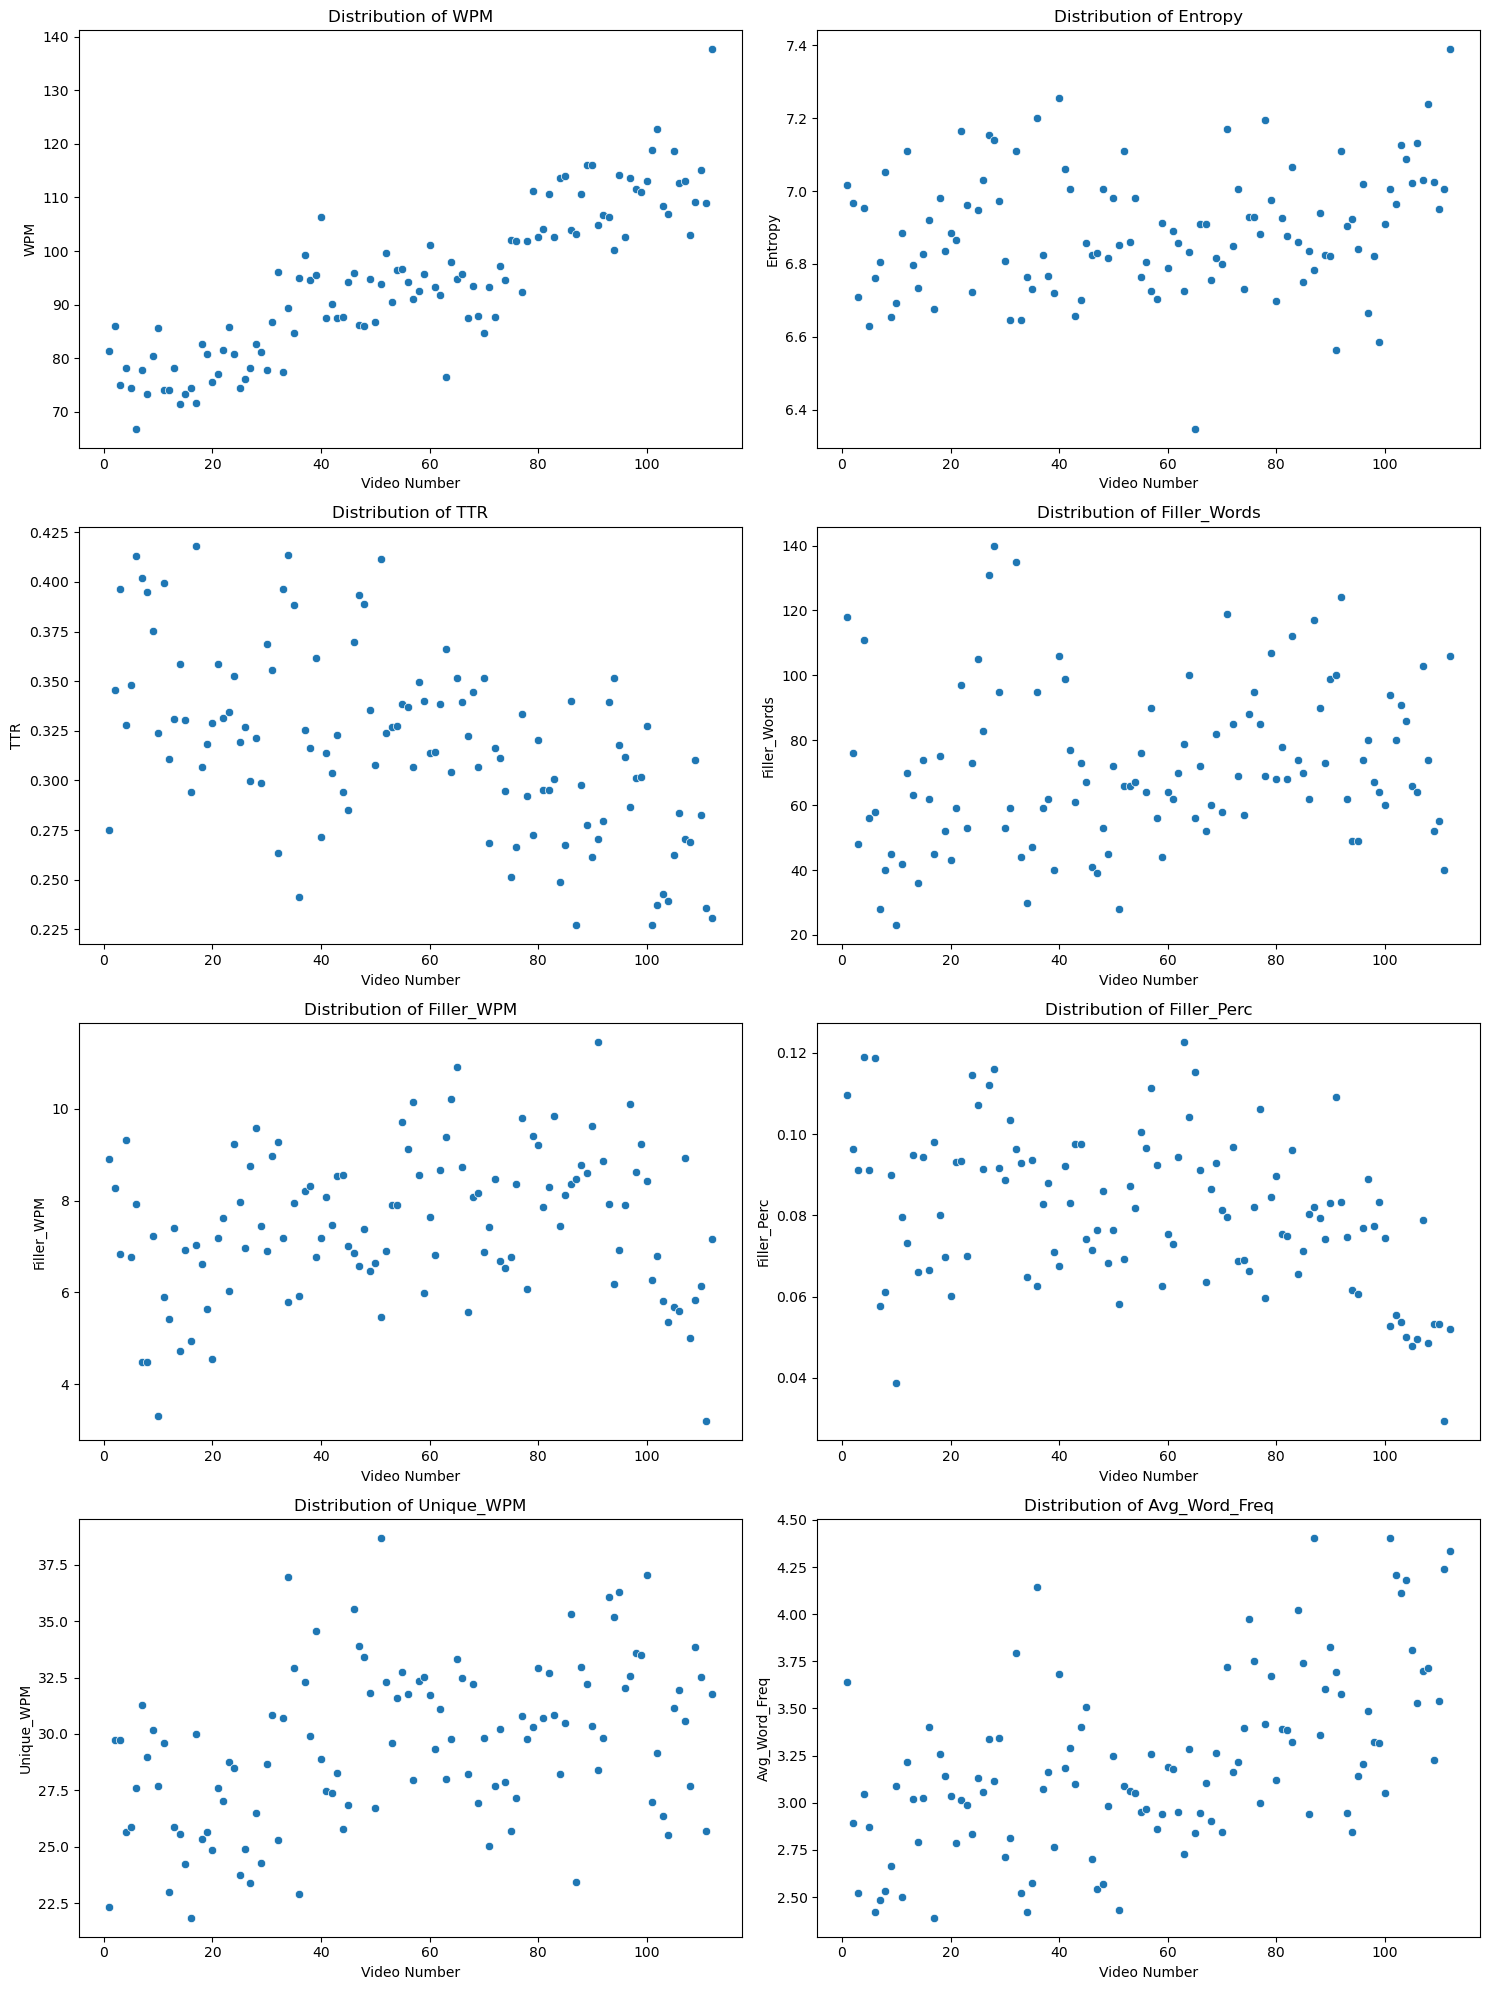

In [113]:
#Creating a 4 row, 2 col grid of linecharts to show the patterns over time all next to eachother (and shorten workbook size)
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.subplots_adjust(hspace=0.4)

#List of variables we want to look at
categories = ["WPM", "Entropy", "TTR", "Filler_Words", "Filler_WPM", "Filler_Perc", 
              "Unique_WPM", "Avg_Word_Freq"]

for i in range(8):
    row, col = divmod(i, 2)  # Get grid position
    sns.scatterplot(data=data, x="Vid_Num", y=categories[i], ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {categories[i]}')  # Set title for each boxplot according to variable name
    axes[row, col].set_xlabel("Video Number")

plt.tight_layout()
plt.show()

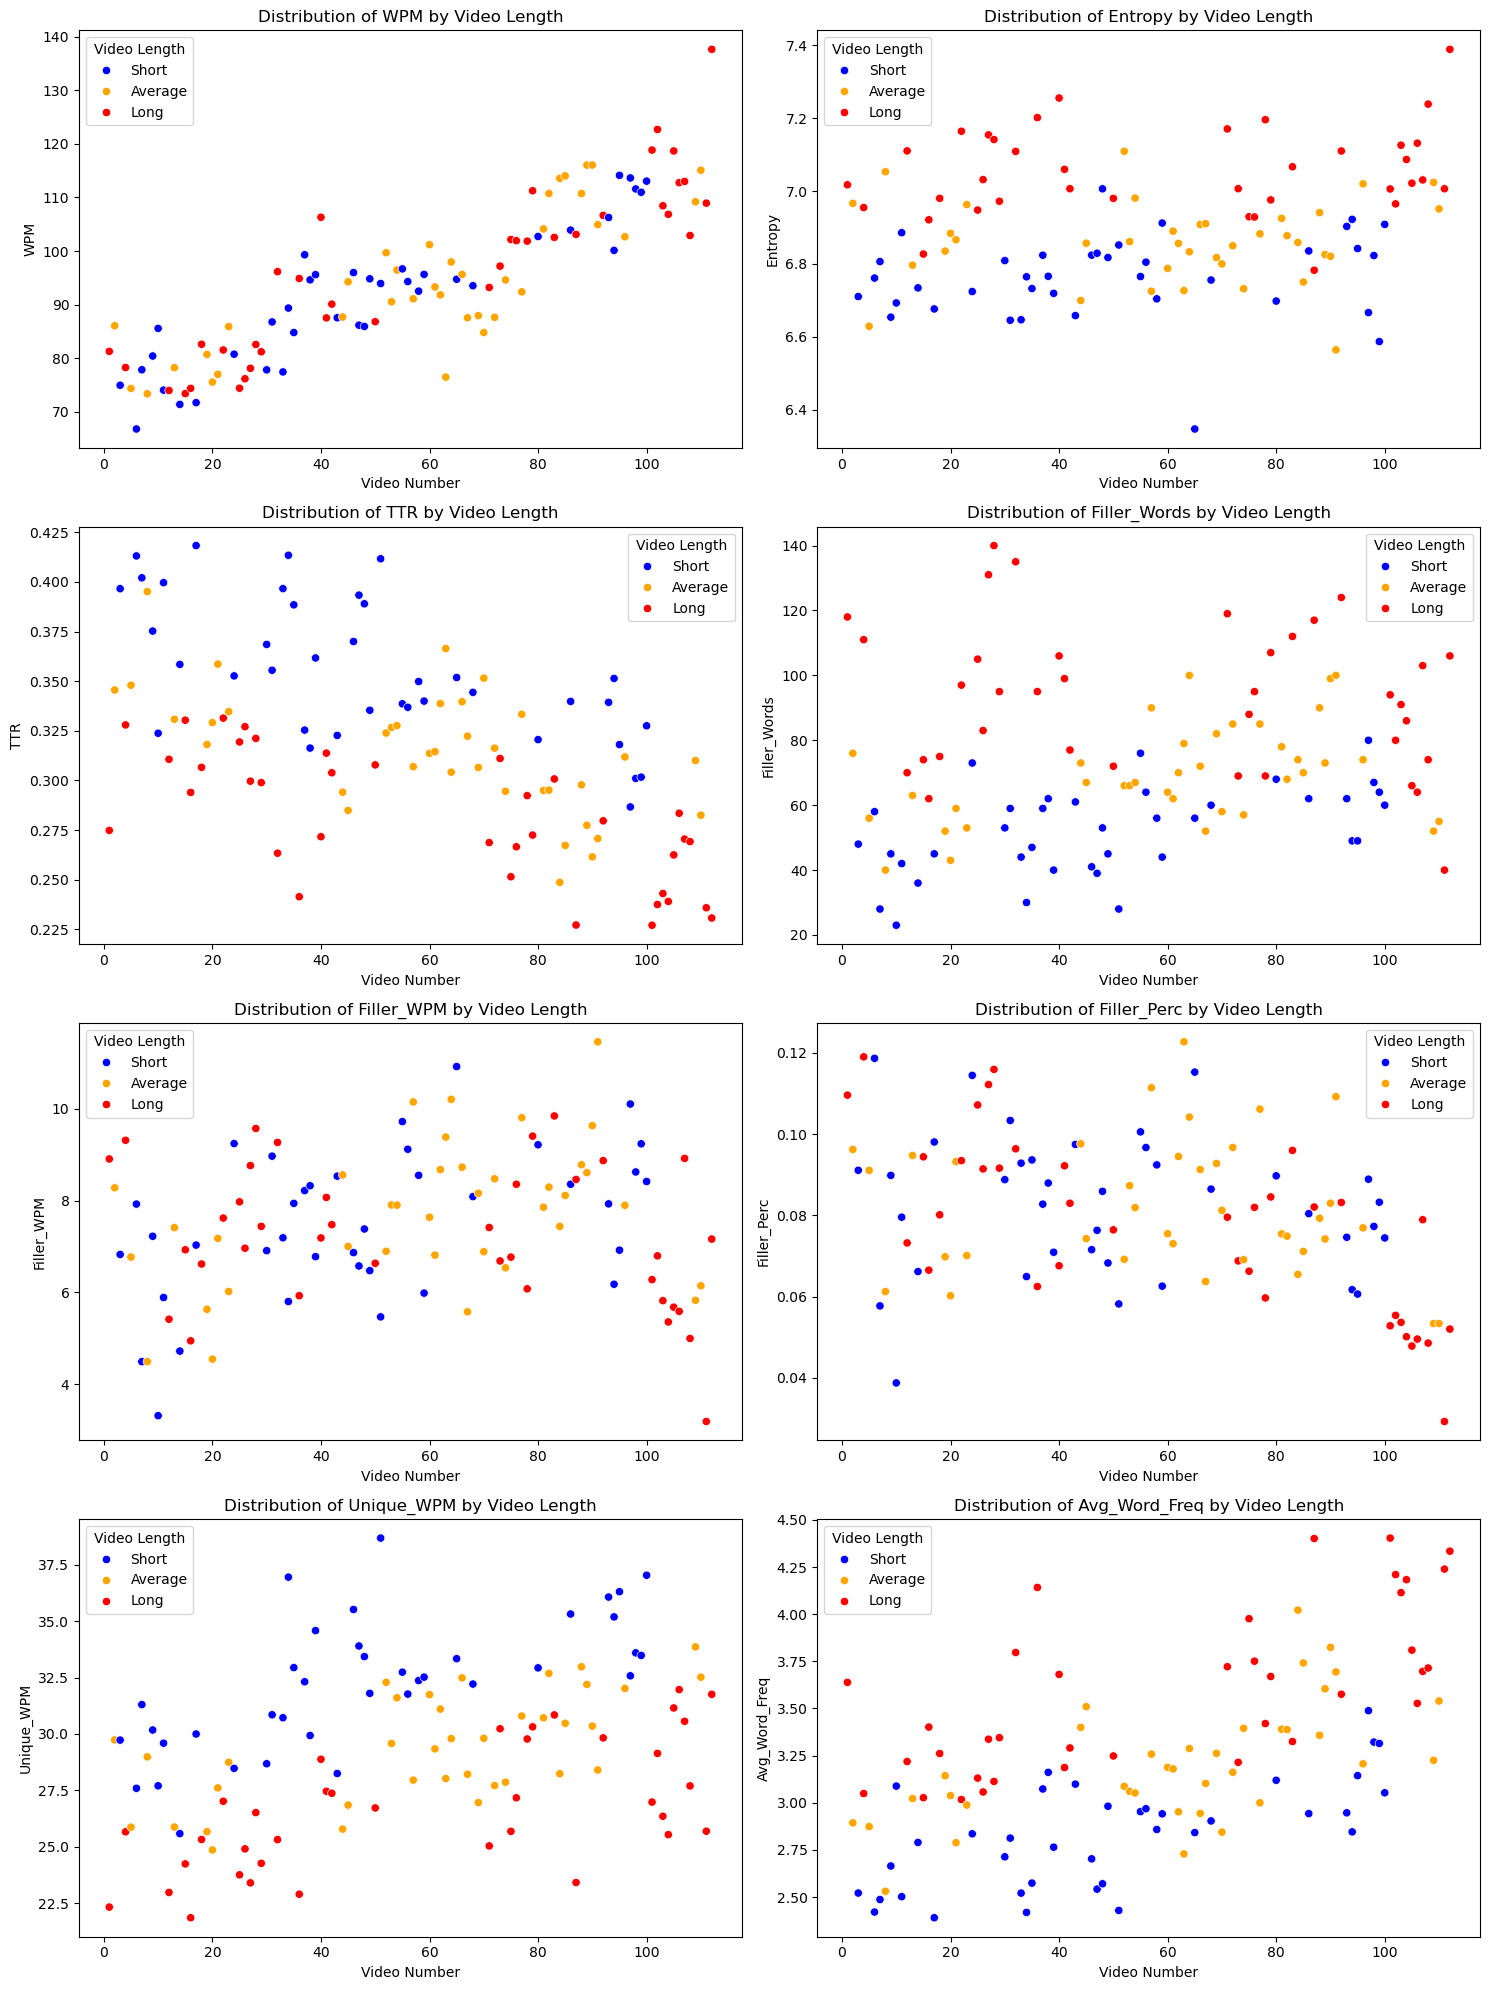

In [111]:
#WPM is clear as day, while the others are a little more convoluded. In the correlation chart we saw that time affected things for filler measures.
#Let's create a categorical variable according to the quantile of video length a video belongs to and replot the data

#I did this at first with 4 and there were too many colors, I think 3 shows enough difference
data["Quantile_Length"] = pd.qcut(data["Length_Minutes"], q=3, labels=["Short", "Average", "Long"])

#Same code as above
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.subplots_adjust(hspace=0.4)

#List of variables we want to look at
categories = ["WPM", "Entropy", "TTR", "Filler_Words", "Filler_WPM", "Filler_Perc", 
              "Unique_WPM", "Avg_Word_Freq"]

#Make this easier to see patterns
colors = {
    "Short" : "Blue", 
    "Average" : "Orange", 
    "Long" : "Red"
}

for i in range(8):
    row, col = divmod(i, 2)  # Get grid position
    sns.scatterplot(data=data, x="Vid_Num", y=categories[i], ax=axes[row, col], hue="Quantile_Length", palette=colors)
    axes[row, col].set_title(f'Distribution of {categories[i]} by Video Length')  # Set title for each boxplot according to variable name
    axes[row, col].set_xlabel("Video Number")
    axes[row, col].legend(title="Video Length")

plt.tight_layout()
plt.show()

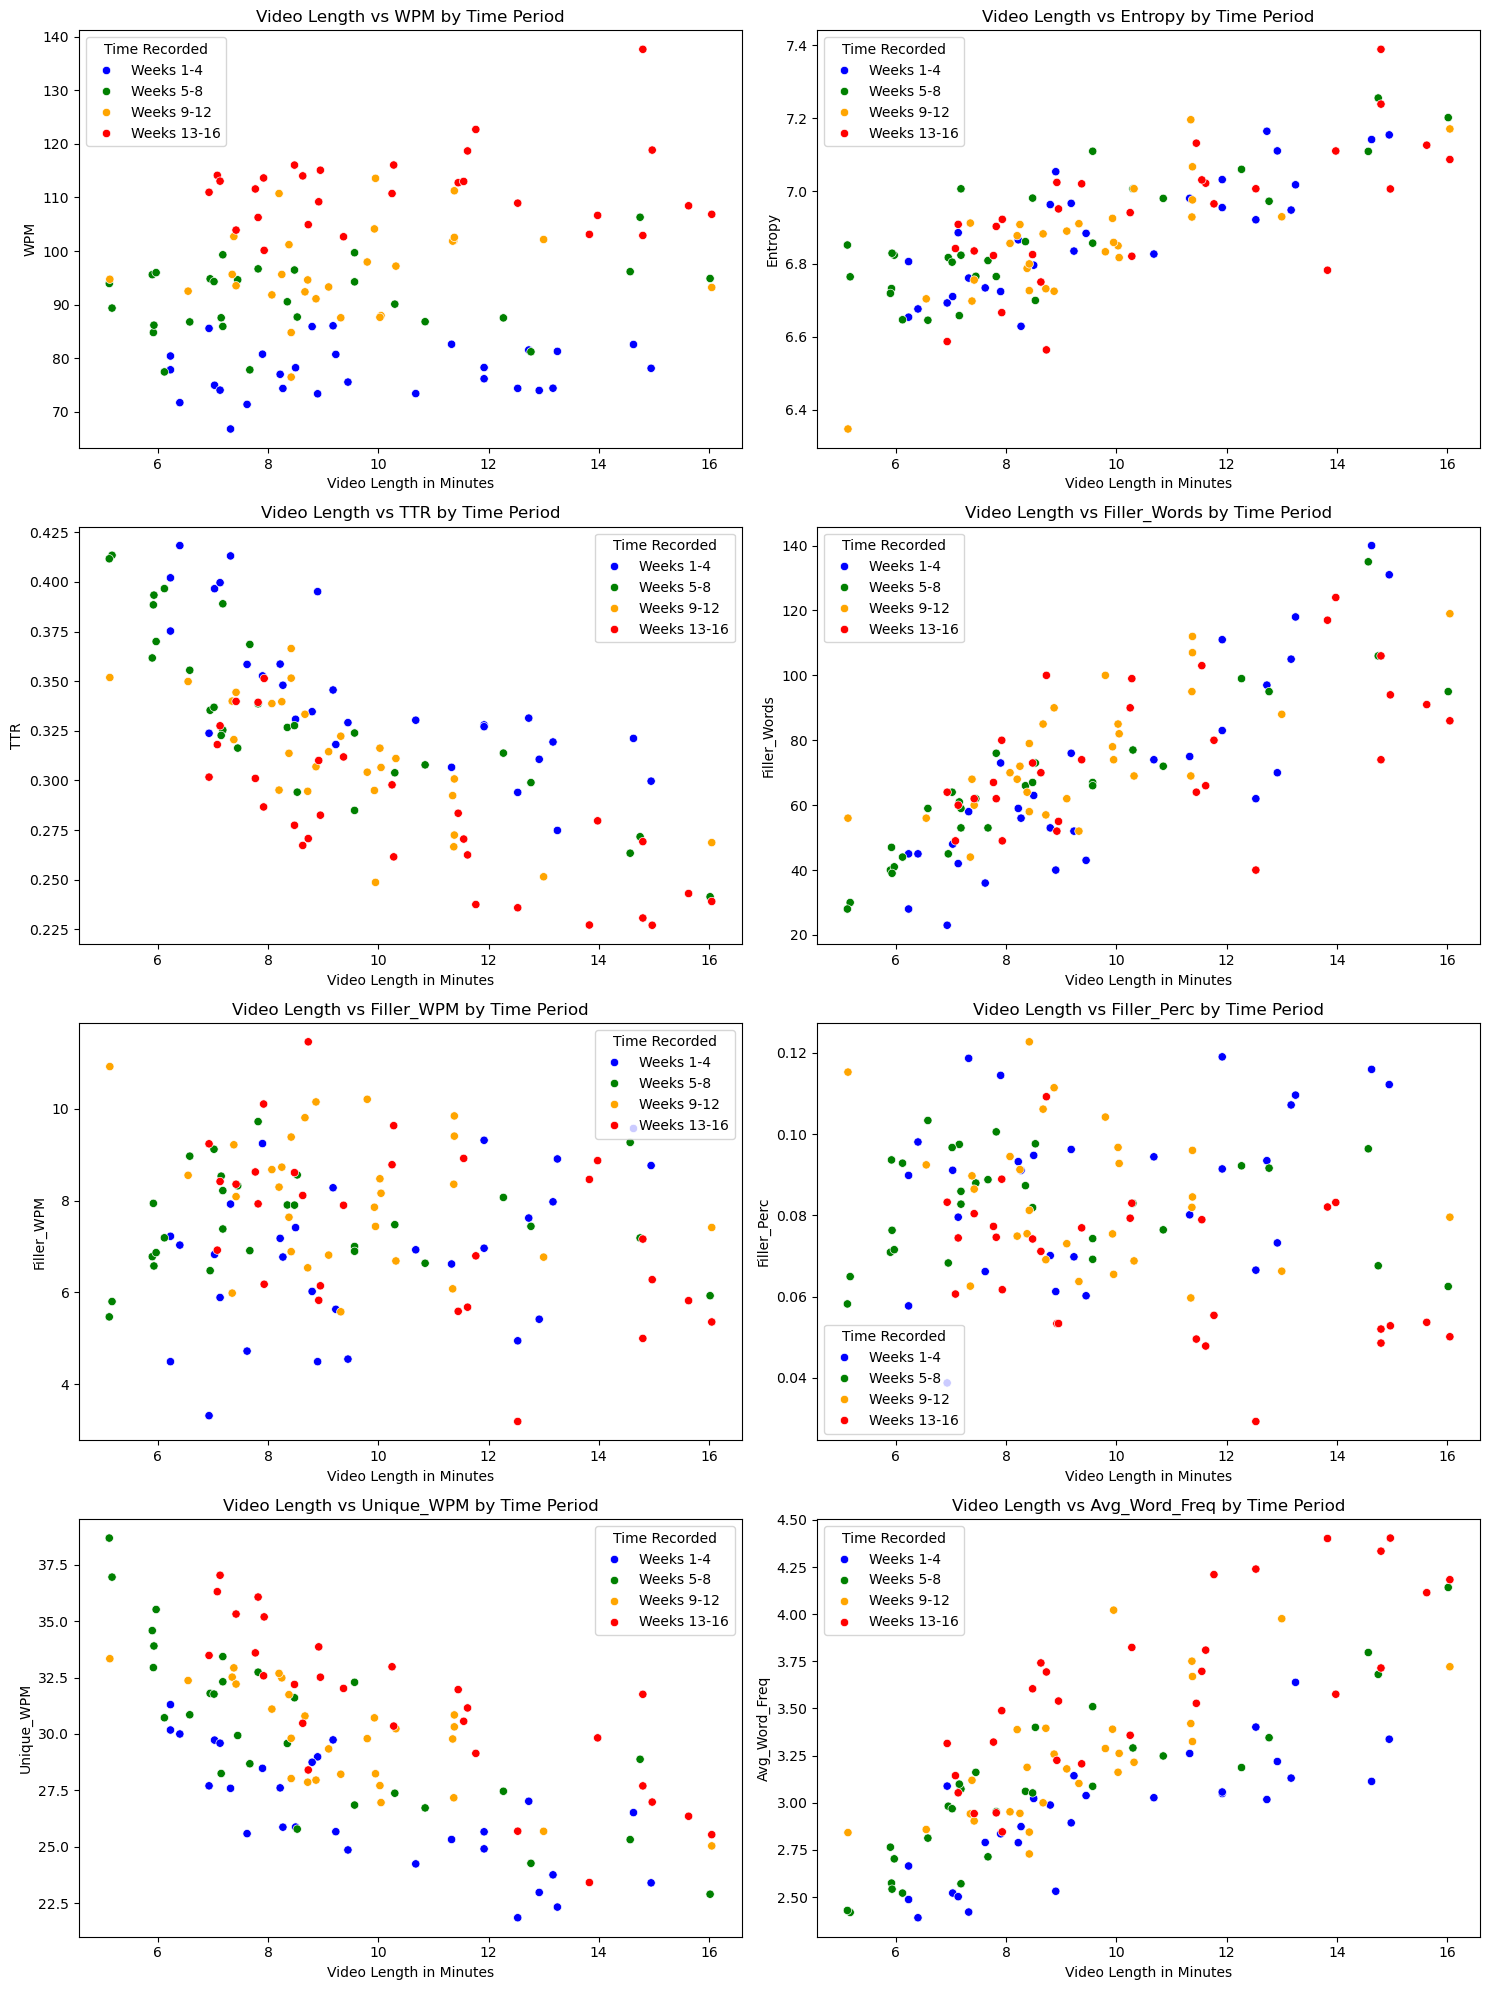

In [185]:
#plotting Length_Minutes vs several variables to see relation

#Going to add a categorical variable to group data into 4 week groups (by quantizing video number).
data["Quantile_VidNum"] = pd.qcut(data["Vid_Num"], q=4, labels=["Weeks 1-4","Weeks 5-8","Weeks 9-12","Weeks 13-16"])

#Same code as above
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.subplots_adjust(hspace=0.4)

#List of variables we want to look at
categories = ["WPM", "Entropy", "TTR", "Filler_Words", "Filler_WPM", "Filler_Perc", 
              "Unique_WPM", "Avg_Word_Freq"]

#Make this easier to see patterns
colors = {
    "Weeks 1-4" : "Blue",
    "Weeks 5-8" : "Green",
    "Weeks 9-12" : "Orange", 
    "Weeks 13-16" : "Red"
}

for i in range(8):
    row, col = divmod(i, 2)  # Get grid position
    sns.scatterplot(data=data, x="Length_Minutes", y=categories[i], ax=axes[row, col], hue="Quantile_VidNum", palette=colors)
    axes[row, col].set_title(f'Video Length vs {categories[i]} by Time Period')  # Set title for each boxplot according to variable name
    axes[row, col].set_xlabel("Video Length in Minutes")
    axes[row, col].legend(title="Time Recorded")

plt.tight_layout()
plt.show()

In [165]:
#Define functions first

#The first 3 functions are from "Feature_Creation.ipynb", the change will come from a filter function that drops filler words (fourth defined)
p_tc_path = Path('./../Data/Processed_Transcripts')

def get_data(transcript_number):
    """Takes transcript number and returns a data dictionary for the corresponding transcript"""
    name = ''
    if transcript_number/10 < 1:
        name = 'p_tc_' + '00' + str(transcript_number) + '.json'
    elif transcript_number/100 < 1:
        name = 'p_tc_' + '0' + str(transcript_number) + '.json'
    else:
        name = 'p_tc_' + str(transcript_number) + '.json'
    file_name = p_tc_path / name
    with open(file_name, 'r') as file:
        data = json.load(file) #ensure_ascii=False ensures us that accents and ~ are maintained
    return data

def calc_entropy(data):
    """Calculates the entropy of the vocabulary used in the video"""
    word_counts = np.array(list(data.values())) #makes it easier to do the probabilities calculation
    probabilities = word_counts / word_counts.sum()
    return entropy(probabilities, base=2)

def calc_ttr(data):
    """Calculates the TTR (unique words / total words) for the data"""
    return len(data.values()) / sum(data.values())

def drop_filler(data):
    #for w, n in data.items():
    for w in ['ah', 'eh', 'hm', 'mm', 'm', 'aa']:
        if w in data:
            print(w, data[w])
            data.pop(w)
    return data

entropy_adj = []
ttr_adj = []

for i in range(112):
    t = get_data(i+1)
    t = drop_filler(t)
    entropy_adj.append(calc_entropy(t))
    ttr_adj.append(calc_trr(t))

data["Entropy_Adj"] = entropy_adj
data["TTR_Adj"] = ttr_adj

ah 103
eh 7
hm 3
mm 2
m 3
ah 66
eh 10
ah 44
eh 4
ah 97
eh 12
mm 1
m 1
ah 45
eh 10
mm 1
ah 38
eh 17
hm 1
mm 1
m 1
ah 21
eh 7
ah 34
eh 6
ah 41
eh 3
mm 1
ah 20
eh 3
ah 33
eh 8
hm 1
ah 61
eh 6
mm 1
m 2
ah 50
eh 12
hm 1
ah 27
eh 4
hm 2
mm 2
m 1
ah 59
eh 14
m 1
ah 50
eh 8
hm 1
m 3
ah 38
eh 6
mm 1
ah 60
eh 9
hm 1
mm 2
m 3
ah 36
eh 11
hm 2
mm 2
m 1
ah 35
eh 8
ah 49
eh 5
hm 1
mm 1
m 3
ah 85
eh 11
mm 1
ah 47
eh 1
mm 2
m 3
ah 61
eh 11
m 1
ah 88
eh 15
mm 2
ah 76
eh 7
ah 120
eh 9
hm 1
m 1
ah 113
eh 25
hm 2
ah 86
eh 8
m 1
ah 42
eh 10
mm 1
ah 52
eh 4
m 3
ah 110
eh 23
hm 1
m 1
ah 36
eh 6
hm 1
m 1
ah 26
eh 4
ah 37
eh 9
m 1
ah 83
eh 11
m 1
ah 45
eh 14
ah 48
eh 14
ah 34
eh 6
ah 94
eh 11
mm 1
ah 83
eh 12
hm 2
m 2
ah 70
eh 5
hm 1
mm 1
ah 45
eh 15
mm 1
ah 62
eh 10
m 1
ah 47
eh 20
ah 39
eh 2
ah 34
eh 5
ah 44
eh 8
hm 1
ah 43
eh 2
ah 62
eh 8
m 2
ah 22
eh 6
ah 59
eh 7
ah 56
eh 9
mm 1
ah 57
eh 8
hm 1
mm 1
ah 69
eh 6
mm 1
ah 50
eh 14
ah 83
eh 7
ah 53
eh 3
ah 37
eh 7
ah 61
eh 2
m 1
ah 49
eh 12
m 1
ah 58
eh 12
ah 7

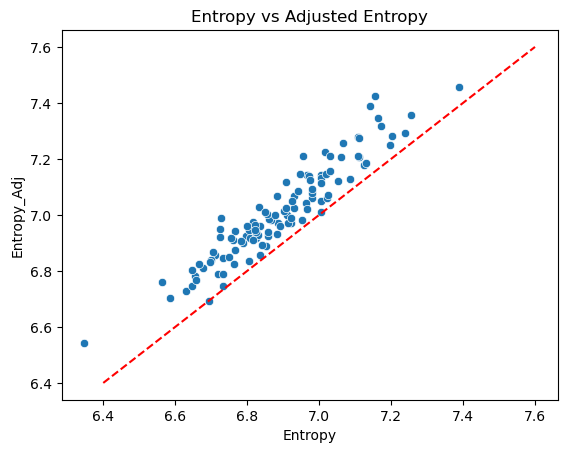

In [151]:
#Create scatterplot to show growth in entropy

sns.scatterplot(data=data, x="Entropy", y="Entropy_Adj")
plt.plot([6.4, 7.6], [6.4, 7.6], color='red', linestyle='--')
plt.title("Entropy vs Adjusted Entropy")
plt.show()

#In general the entropy increased for all values, I'm not sure if this will change our insights

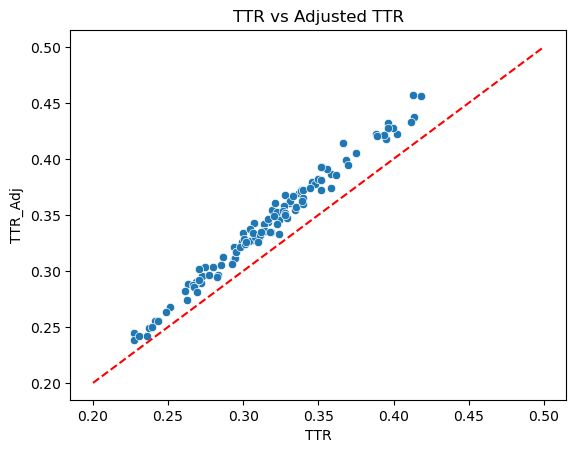

In [171]:
#Create scatterplot to show growth in TTR

sns.scatterplot(data=data, x="TTR", y="TTR_Adj")
plt.plot([0.2, 0.5], [0.2, 0.5], color='red', linestyle='--')
plt.title("TTR vs Adjusted TTR")
plt.show()

#In general TRR increased, and increased more for higher numbers, which makes sense since it is calculated as an inverse.

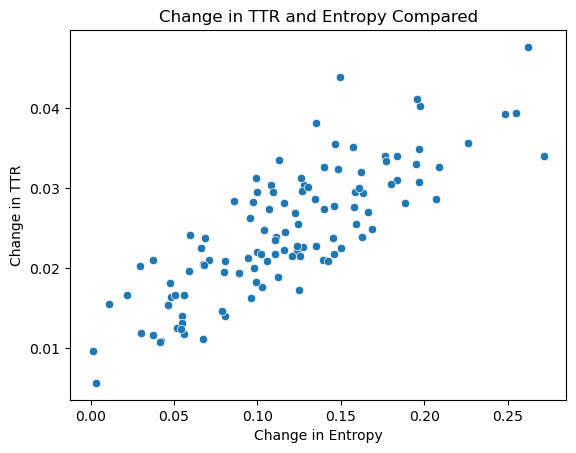

In [173]:
#Now I want to look at change in TTR vs change in Entropy

Entropy_Chg = data["Entropy_Adj"] - data["Entropy"]
TTR_Chg = data["TTR_Adj"] - data["TTR"]

sns.scatterplot(x=Entropy_Chg, y=TTR_Chg)
plt.title("Change in TTR and Entropy Compared")
plt.xlabel("Change in Entropy")
plt.ylabel("Change in TTR")
plt.show()

#While in general there is change, change is not always constant, that is they are well correlated but some observations changed a lot in one variable
#   and not the other. Let's see how this affected the trends of the two over time

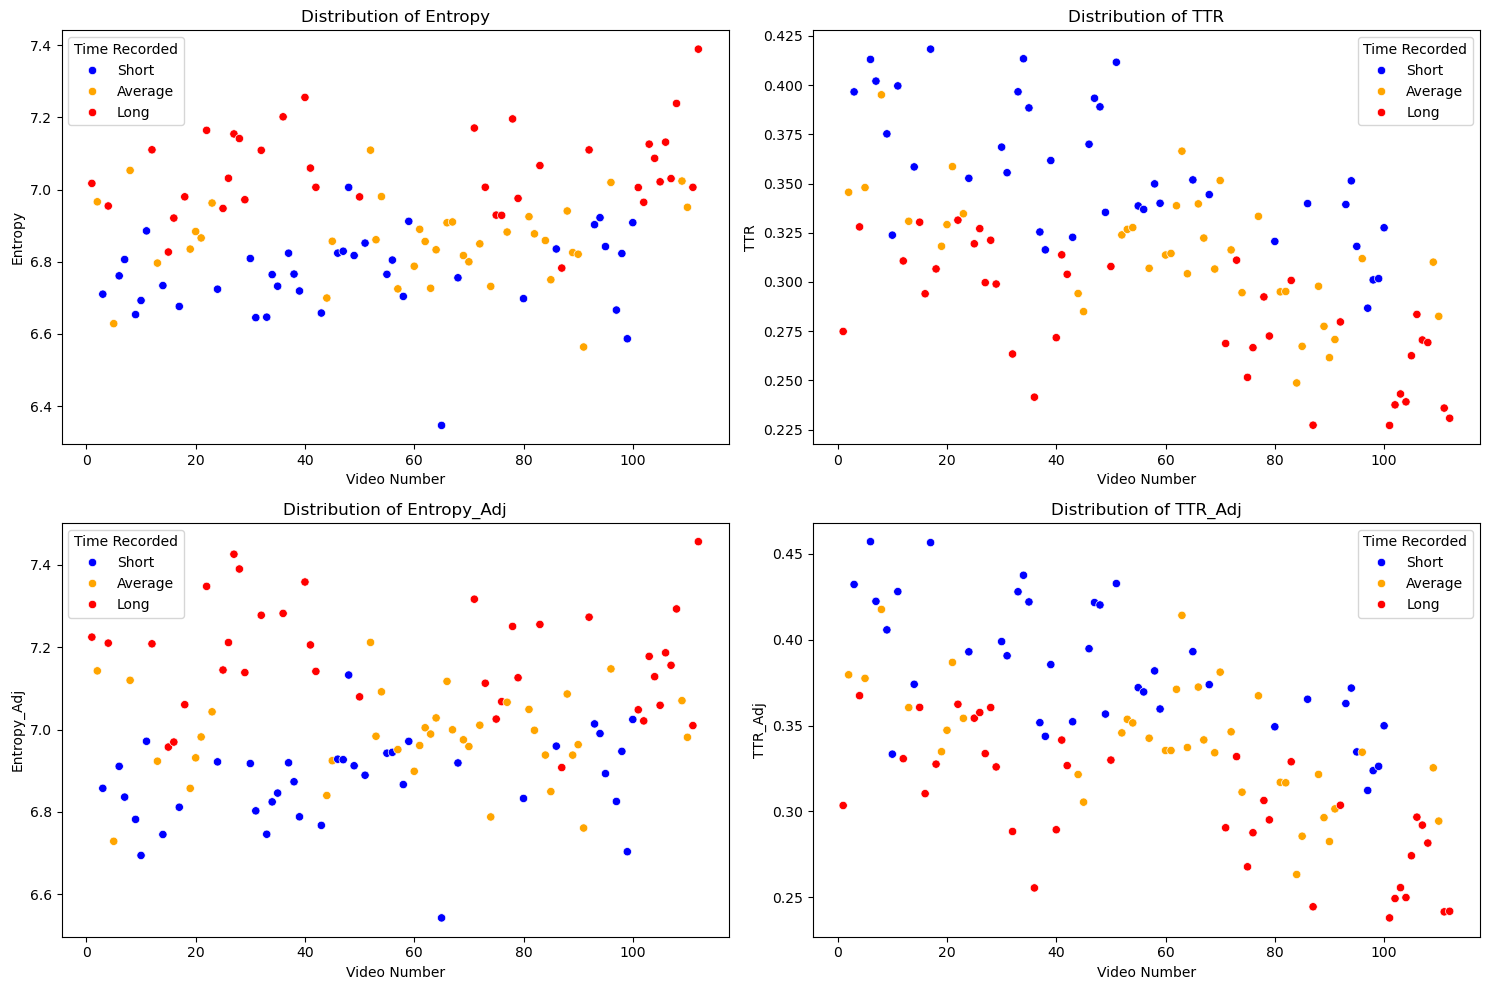

In [181]:
#Creating a 4 row, 2 col grid of linecharts to show the patterns over time all next to eachother (and shorten workbook size)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4)

#List of variables we want to look at
categories = ["Entropy", "TTR", "Entropy_Adj", "TTR_Adj"]

colors = {
    "Short" : "Blue", 
    "Average" : "Orange", 
    "Long" : "Red"
}

for i in range(4):
    row, col = divmod(i, 2)  # Get grid position
    sns.scatterplot(data=data, x="Vid_Num", y=categories[i], ax=axes[row, col], hue="Quantile_Length", palette=colors)
    axes[row, col].set_title(f'Distribution of {categories[i]}')  # Set title for each boxplot according to variable name
    axes[row, col].set_xlabel("Video Number")
    axes[row, col].legend(title="Time Recorded")

plt.tight_layout()
plt.show()

#Overall patterns are still the same since the data was so noisy. I think the Adjusted way is a better measurement for comparison to other
#    speaking datasets, but for showing trends both are sufficient. Continuing with Adjusted measurements

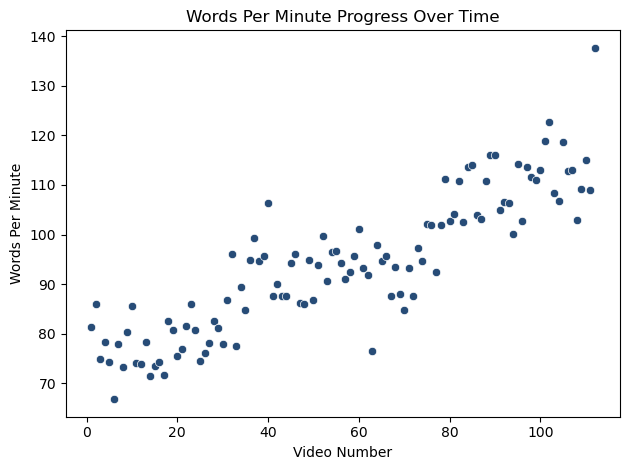

In [213]:
#Charts to export for sharing

#WPM first
sns.scatterplot(data=data, x="Vid_Num", y="WPM", color="#274c77")
plt.title('Words Per Minute Progress Over Time') 
plt.xlabel("Video Number")
plt.ylabel("Words Per Minute")

plt.tight_layout()
plt.savefig("WPM_Time")
plt.show()

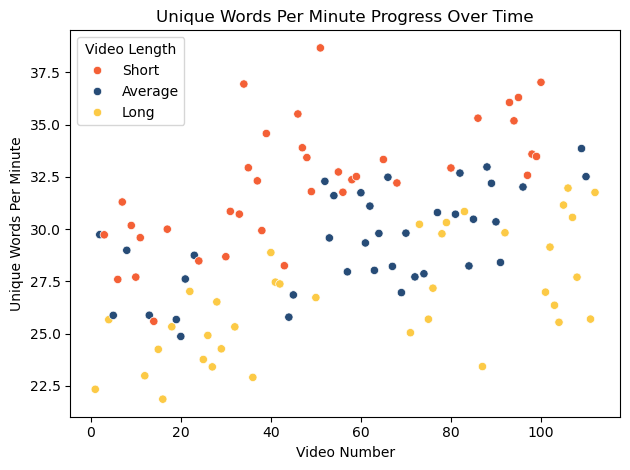

In [211]:
#Now the Unique WPM but with a better color palette


#Colors: #f46036, #274c77, #fcca46

colors = {
    "Short" : "#f46036", 
    "Average" : "#274c77", 
    "Long" : "#fcca46"
}


sns.scatterplot(data=data, x="Vid_Num", y="Unique_WPM", hue="Quantile_Length", palette=colors)
plt.title('Unique Words Per Minute Progress Over Time')  
plt.xlabel("Video Number")
plt.legend(title="Video Length")
plt.ylabel("Unique Words Per Minute")

plt.tight_layout()
plt.savefig("Unique_WPM_Time")
plt.show()

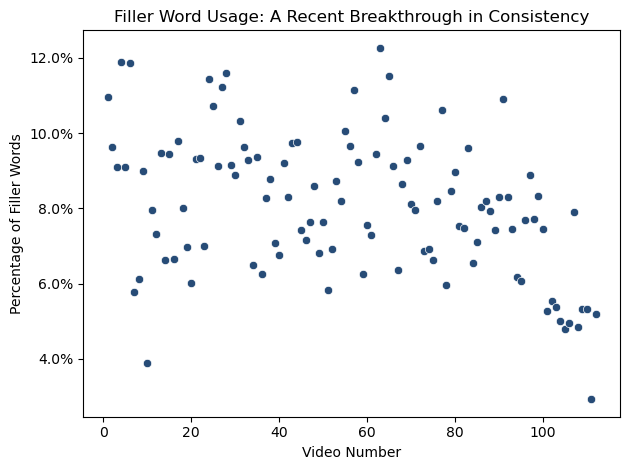

In [219]:
#Now the Filler_Perc chart
from matplotlib.ticker import PercentFormatter

sns.scatterplot(data=data, x="Vid_Num", y="Filler_Perc", color="#274c77")
plt.title('Filler Word Usage: A Recent Breakthrough in Consistency') 
plt.xlabel("Video Number")
plt.ylabel("Percentage of Filler Words")

#Getting y-axis to be labeled in percentages
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.tight_layout()
plt.savefig("Filler_Perc_Time")
plt.show()